## Load Data - Train with Subaru and Test with VW

In [3]:
#DATASET PREPERATION
%matplotlib inline
import torch
import random
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.model_selection import train_test_split
from scipy.interpolate import CubicSpline      
from transforms3d.axangles import axangle2mat  
import copy

start_no = 0
range_len = 50000
train_set = np.zeros((1,range_len))
test_set = np.zeros((1,range_len))
num_datapoints = 20

data = sio.loadmat('../accelane_mat_v3/SBSB_6Khz_preprocessed_AccZ.mat')
for i in range (num_datapoints):     
    varName = "accZ_L{}T{}_p".format(2 if i < 10 else 3, (i%10)+1)
    curr = np.asarray(data[varName][start_no : start_no+range_len]).reshape(1,range_len)
    train_set = np.append(train_set, curr, axis = 0)
train_set = np.delete(train_set, (0), axis=0) 

data = sio.loadmat('../accelane_mat_v3/VWVW_preprocessed_AccZ.mat')
for i in range (num_datapoints):
    varName = "accZ_L{}T{}_p".format(2 if i < 10 else 3, (i%10)+1)
    curr = np.asarray(data[varName][start_no : start_no+range_len]).reshape(1,range_len)
    test_set = np.append(test_set, curr, axis = 0)
test_set = np.delete(test_set, (0), axis=0)

train_labels = np.concatenate(
    (np.zeros(num_datapoints//2).astype(int), np.ones(num_datapoints//2).astype(int))).reshape(num_datapoints, 1)
test_labels = copy.deepcopy(train_labels)

train_set = np.append(train_set, train_labels, axis = 1)
test_set = np.append(test_set, test_labels, axis = 1)

train_targets_numpy = train_set[:,-1]
train_features_numpy = train_set[:,:-1]
print("Train Features numpy {}".format(train_features_numpy.shape))
print("Train Targets numpy {}".format(train_targets_numpy.shape))

test_targets_numpy = test_set[:,-1]
test_features_numpy = test_set[:,:-1]
print("Test Features numpy {}".format(test_features_numpy.shape))
print("Test Targets numpy {}".format(test_targets_numpy.shape))

num_original_samples = num_datapoints
features_numpy_new = train_features_numpy.T

Train Features numpy (20, 50000)
Train Targets numpy (20,)
Test Features numpy (20, 50000)
Test Targets numpy (20,)


## Training Data Augmentation

### Jittering

In [4]:
def DA_Jitter(X, sigma= 0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X+myNoise

sigma = np.linspace(.1,1,22)
for j in sigma:
    for i in range(num_original_samples):
        train_features_numpy = np.append(train_features_numpy, DA_Jitter(features_numpy_new[:,i], j).reshape(1,-1), axis = 0)
    train_targets_numpy = np.append(train_targets_numpy, train_targets_numpy[:num_original_samples], axis = 0)
print('FeaturesNumpy Output shape after jittering')
print(train_features_numpy.shape)
print('TargetsNumpy Output shape after jittering')
print(train_targets_numpy.shape)

FeaturesNumpy Output shape after jittering
(460, 50000)
TargetsNumpy Output shape after jittering
(460,)


### Scaling

In [14]:
def DA_Scaling(X, sigma=0.1):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise

sigma = np.linspace(.2,2,22)
for j in sigma:
    for i in range(num_original_samples):
        train_features_numpy = np.append(train_features_numpy, DA_Scaling(features_numpy_new[:,i].reshape(-1,1), j).reshape(1,-1), axis = 0)
    train_targets_numpy = np.append(train_targets_numpy, train_targets_numpy[:num_original_samples], axis = 0)
print('FeaturesNumpy Output shape after scaling')
print(train_features_numpy.shape)
print('TargetsNumpy Output shape after scaling')
print(train_features_numpy.shape)

FeaturesNumpy Output shape after scaling
(2140, 50000)
TargetsNumpy Output shape after scaling
(2140, 50000)


### Magnitude Warping

In [6]:
from scipy.interpolate import CubicSpline

def GenerateRandomCurves(X, sigma=0.2, knot=4):
    xx = (np.ones((X.shape[1],1))*(np.arange(0,X.shape[0], (X.shape[0]-1)/(knot+1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    cs_x = CubicSpline(xx[:,0], yy[:,0])
    return np.array([cs_x(x_range)]).transpose()

def DA_MagWarp(X, sigma):
    return X * GenerateRandomCurves(X, sigma)

sigma = np.linspace(.2,2,22)
for j in sigma:
    for i in range(num_original_samples):
        train_features_numpy = np.append(train_features_numpy, DA_MagWarp(features_numpy_new[:,i].reshape(-1,1), j).reshape(1,-1), axis = 0)
    train_targets_numpy = np.append(train_targets_numpy, train_targets_numpy[:num_original_samples], axis = 0)
print('FeaturesNumpy Output shape after magwarping')
print(train_features_numpy.shape)
print('TargetsNumpy Output shape after magwarping')
print(train_targets_numpy.shape)

FeaturesNumpy Output shape after magwarping
(1340, 50000)
TargetsNumpy Output shape after magwarping
(1340,)


### Time Warping

In [7]:
#DATA AUGMENTATION
#SINGLE KERNEL 

from scipy.interpolate import CubicSpline

#perform time warping
def GenerateRandomCurvesWithZ(X, sigma=0.2, knot=4):
    xx = (np.ones((X.shape[1],1))*(np.arange(0,X.shape[0], (X.shape[0]-1)/(knot+1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    cs_x = CubicSpline(xx[:,0], yy[:,0])
    cs_y = CubicSpline(xx[:,1], yy[:,1])
    cs_z = CubicSpline(xx[:,2], yy[:,2])
    return np.array([cs_x(x_range),cs_y(x_range),cs_z(x_range)]).transpose()

def DistortTimesteps(X, sigma=0.2):
    tt = GenerateRandomCurvesWithZ(X, sigma) # Regard these samples aroun 1 as time intervals
    tt_cum = np.cumsum(tt, axis=0)        # Add intervals to make a cumulative graph
    # Make the last value to have X.shape[0]    
    t_scale = [(X.shape[0]-1)/tt_cum[-1,0],(X.shape[0]-1)/tt_cum[-1,1],(X.shape[0]-1)/tt_cum[-1,2]]
    tt_cum[:,0] = tt_cum[:,0]*t_scale[0]
    tt_cum[:,1] = tt_cum[:,1]*t_scale[1]
    tt_cum[:,2] = tt_cum[:,2]*t_scale[2]
    return tt_cum

def DA_TimeWarp(X, sigma=0.2):
    tt_new = DistortTimesteps(X, sigma)
    X_new = np.zeros(X.shape)
    x_range = np.arange(X.shape[0])
    X_new[:,0] = np.interp(x_range, tt_new[:,0], X[:,0])
    X_new[:,1] = np.interp(x_range, tt_new[:,1], X[:,1])
    X_new[:,2] = np.interp(x_range, tt_new[:,2], X[:,2])
    return X_new

n_sets_time_warping = 1
sigma = np.linspace(.1, 1, 20)
upper_lim = num_original_samples-(num_original_samples%3)
for j in sigma:
    for i in range(0,upper_lim, 3):
        ip = features_numpy_new[:,i:i+3]
        time_warped_ip = DA_TimeWarp(ip, j).T
        train_features_numpy = np.append(train_features_numpy, DA_TimeWarp(ip, j).T , axis = 0)
    train_targets_numpy = np.concatenate((train_targets_numpy,train_targets_numpy[:upper_lim]), axis=None)
print('FeaturesNumpy Output shape after time warping')
print(train_features_numpy.shape)
print('TargetsNumpy Output shape after time warping')
print(train_targets_numpy.shape)

FeaturesNumpy Output shape after time warping
(1700, 50000)
TargetsNumpy Output shape after time warping
(1700,)


### Save Full Dataset

In [8]:
np.save("TrainData50KCrossCar.npy", train_features_numpy)
np.save("TrainLabels50KCrossCar.npy", train_targets_numpy)
np.save("TestData50KCrossCar.npy", test_features_numpy)
np.save("TestLabels50KCrossCar.npy", test_targets_numpy)

## Partition Validation Dataset For Training

In [31]:
from functools import reduce
def factors(n):    
    return set(reduce(list.__add__, 
                ([i, n//i] for i in range(1, int(n**0.5) + 1) if n % i == 0)))
features_train, features_val, targets_train, targets_val = train_test_split(train_features_numpy,
                                                                             train_targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42)


featuresTrain = torch.from_numpy(features_train).type(torch.FloatTensor)
targetsTrain = torch.from_numpy(targets_train).type(torch.FloatTensor)
featuresVal = torch.from_numpy(features_val).type(torch.FloatTensor)
targetsVal = torch.from_numpy(targets_val).type(torch.FloatTensor)

train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
val = torch.utils.data.TensorDataset(featuresVal,targetsVal)

potential_batch_size_train = sorted(factors(features_train.shape[0]))
potential_batch_size_val = sorted(factors(features_val.shape[0]))

min_batch_train = 32
min_batch_val = 20

batch_size = potential_batch_size_train[np.argmax(np.asarray(potential_batch_size_train) >= min_batch_train )]
batch_size_val = potential_batch_size_val[np.argmax(np.asarray(potential_batch_size_val) >= min_batch_val)]

train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val, batch_size = batch_size_val, shuffle = True)


print('Shape of Features Train Dataset')
print(featuresTrain.size())
print('Shape of Targets Train Dataset')
print(targetsTrain.size())
print('Shape of Features Validation Dataset')
print(featuresVal.size())
print('Shape of Targets Validation Dataset')
print(targetsVal.size())

print("Batch Size - Train: {} Val: {}".format(batch_size, batch_size_val))

Shape of Features Train Dataset
torch.Size([1712, 50000])
Shape of Targets Train Dataset
torch.Size([1712])
Shape of Features Validation Dataset
torch.Size([428, 50000])
Shape of Targets Validation Dataset
torch.Size([428])
Batch Size - Train: 107 Val: 107


## Model Design

In [32]:
# class ConvNet(nn.Module):
#     def __init__(self):
#         super(ConvNet, self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Conv1d(in_channels = 1, out_channels = filters,kernel_size=1000, stride=10),
#             nn.ReLU(),
#             nn.BatchNorm1d(filters))
#         self.layer2 = nn.Sequential(
#             nn.Conv1d(in_channels = filters, out_channels = filters, kernel_size=101, stride=10),
#             nn.ReLU(),
#             nn.BatchNorm1d(filters))
#         self.layer3 = nn.Sequential(
#             nn.Conv1d(in_channels = filters, out_channels = filters, kernel_size=11, stride=5),
#             nn.ReLU(),
#             nn.BatchNorm1d(filters))
#         self.avgLayer = nn.AvgPool1d(5, stride = 2)
#         self.fc1 = nn.Linear(796,2)

num_filters = 3
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels = 1, out_channels = num_filters,kernel_size=25, stride=10),
            nn.ReLU(),
            nn.BatchNorm1d(num_filters))
        self.avgLayer1 = nn.AvgPool1d(5, stride = 2)
        self.layer2 = nn.Sequential(
            nn.Conv1d(in_channels = num_filters, out_channels = num_filters, kernel_size=10, stride=5),
            nn.ReLU(),
            nn.BatchNorm1d(num_filters))
        self.layer3 = nn.Sequential(
            nn.Conv1d(in_channels = num_filters, out_channels = num_filters, kernel_size=10, stride=3),
            nn.ReLU(),
            nn.BatchNorm1d(num_filters))
        self.avgLayer2 = nn.AvgPool1d(10, stride = 2)
        self.drop_out = nn.Dropout(.3)
        self.fc1 = nn.Linear(231,2)


    def forward(self, x):
        out = self.layer1(x)
        out = self.avgLayer1(out)
        out = self.layer2(out)
        out = self.layer3(out) 
        out = self.avgLayer2(out)
        out = self.drop_out(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        return out

    def init_hidden(self,batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        return Variable(hidden)
    
    
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        torch.nn.init.xavier_uniform(m.weight.data, nn.init.calculate_gain('relu'))
        m.bias.data.zero_()
    

model = ConvNet()
optimizer = optim.SGD(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()
model

ConvNet(
  (layer1): Sequential(
    (0): Conv1d(1, 3, kernel_size=(25,), stride=(10,))
    (1): ReLU()
    (2): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (avgLayer1): AvgPool1d(kernel_size=(5,), stride=(2,), padding=(0,))
  (layer2): Sequential(
    (0): Conv1d(3, 3, kernel_size=(10,), stride=(5,))
    (1): ReLU()
    (2): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): Sequential(
    (0): Conv1d(3, 3, kernel_size=(10,), stride=(3,))
    (1): ReLU()
    (2): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (avgLayer2): AvgPool1d(kernel_size=(10,), stride=(2,), padding=(0,))
  (drop_out): Dropout(p=0.3)
  (fc1): Linear(in_features=231, out_features=2, bias=True)
)

## Model Training

/home/mharisha/.local/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Current Epoch: 0
Iteration: 1 Loss: 0.40409716963768005 Accuracy: 72 %
Current Epoch: 1
Iteration: 2 Loss: 0.30474165081977844 Accuracy: 91 %
Current Epoch: 2
Iteration: 3 Loss: 0.24993309378623962 Accuracy: 94 %
Current Epoch: 3
Iteration: 4 Loss: 0.23556120693683624 Accuracy: 94 %
Current Epoch: 4
Iteration: 5 Loss: 0.13631726801395416 Accuracy: 95 %
Current Epoch: 5
Iteration: 6 Loss: 0.22912351787090302 Accuracy: 95 %
Current Epoch: 6
Iteration: 7 Loss: 0.22845293581485748 Accuracy: 95 %
Current Epoch: 7
Iteration: 8 Loss: 0.16766788065433502 Accuracy: 95 %
Current Epoch: 8
Iteration: 9 Loss: 0.14783276617527008 Accuracy: 94 %
Current Epoch: 9
Iteration: 10 Loss: 0.1487005203962326 Accuracy: 95 %
Current Epoch: 10
Iteration: 11 Loss: 0.12006901949644089 Accuracy: 96 %
Current Epoch: 11
Iteration: 12 Loss: 0.14555266499519348 Accuracy: 96 %
Current Epoch: 12
Iteration: 13 Loss: 0.07630205899477005 Accuracy: 94 %
Current Epoch: 13
Iteration: 14 Loss: 0.13553304970264435 Accuracy: 95 

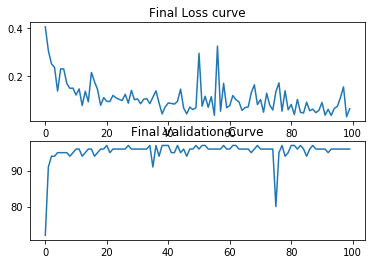

In [33]:
model.apply(weights_init)
num_epochs = 100
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
n_classes = 2

for epoch in range(num_epochs):
    print('Current Epoch: {}'.format(epoch))
    for i, (samples, targets) in enumerate(train_loader):
        train = Variable(samples.view(batch_size,1,-1))
        targets = Variable(targets.type(torch.LongTensor))
        # Clear gradients
        optimizer.zero_grad()
        #setting up model for training
        model.train()
        # Forward propagation
        outputs = model(train)
        outputs = outputs.reshape(batch_size,2)
        # Calculate softmax and cross entropy loss
        loss = criterion(outputs, targets)
        # Calculating gradients
        loss.backward()
        # Update parameters
        optimizer.step()
    count += 1
    #accuracy at the end of epoch    
    correct = 0
    total = 0
    # Predict test dataset
    for samples, labels in val_loader:
        test = Variable(samples.view(batch_size_val,1,-1))
        #setting up in test mode
        model.eval()
        # Forward propagation
        outputs = model(test)
        outputs = outputs.view(batch_size_val, n_classes)
        # Get predictions from the maximum value
        predicted = torch.max(outputs.data, 1)[1].type(torch.FloatTensor)
        # Total number of labels
        total += len(labels)
        # Total correct predictions
        correct += (predicted == labels).sum()
    accuracy = 100 * correct / float(total)
    loss_list.append(loss.data)
    iteration_list.append(count)
    accuracy_list.append(accuracy)

    print('Iteration: {} Loss: {} Accuracy: {} %'.format(count, loss.data.item(), accuracy))

plt.subplot(2,1,1)
plt.title('Final Loss curve')
plt.plot(loss_list)
plt.subplot(2,1,2)
plt.title('Final Validation Curve')
plt.plot(accuracy_list)

## Model Testing

In [34]:
# import matplotlib.pyplot as plt
# import copy
# sample_size = 1
# fig, ax = plt.subplots(2, 8, sharex=True, sharey=True)
# for i in range(test_features_numpy.shape[0]):
#     startNum = np.random.randint(range_len-sample_size)
#     sub_test_features_numpy = copy.deepcopy(test_features_numpy)
#     sub_test_features_numpy[i][:startNum] = [0]
#     sub_test_features_numpy[startNum + sample_size:] = [0]
    
#     ax[0][i].plot(np.arange(sample_size),sub_test_features_numpy[i][startNum:startNum+sample_size])
#     ax[1][i].plot(np.arange(range_len),test_features_numpy[i][:])

test_features = torch.from_numpy(test_features_numpy).type(torch.FloatTensor)
test_targets = torch.from_numpy(test_targets_numpy).type(torch.FloatTensor)
test_totalDataset = torch.utils.data.TensorDataset(test_features,test_targets)
batch_size_test = test_features_numpy.shape[0]
test_loader = torch.utils.data.DataLoader(test_totalDataset, batch_size = batch_size_test, shuffle = True)


print('Testing dataset dimensions')
print('Shape of Features Dataset')
print(test_features.size())
print('Shape of Targets Dataset')
print(test_targets.size())
print("Batch Size: {}".format(batch_size_test))

Testing dataset dimensions
Shape of Features Dataset
torch.Size([20, 50000])
Shape of Targets Dataset
torch.Size([20])
Batch Size: 20


In [35]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

accuracy_list = []
f1_score_list = []
precision_list = []
recall_list = []
y_pred =[]
y_true = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
            samples, labels = data
            samples = Variable(samples.view(batch_size_test,1,-1))
            
            model.eval()
            
            outputs = model(samples)
            outputs = outputs.view(batch_size_test, n_classes)
            
            predictions = torch.argmax(outputs, 1)
            targets = labels
            
            y_pred.extend(predictions)
            y_true.extend(targets)



conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)
print("Accuracy Score: {}".format(accuracy_score(y_true, y_pred) * 100))
print("F1 Score: {}". format(f1_score(y_true, y_pred) * 100))
print("Precision Score: {}".format(precision_score(y_true, y_pred) * 100))
print("Recall Score: {}".format(recall_score(y_true, y_pred)* 100))

[[9 1]
 [3 7]]
Accuracy Score: 80.0
F1 Score: 77.77777777777777
Precision Score: 87.5
Recall Score: 70.0


## Debug - Visualizing Test vs Train Data

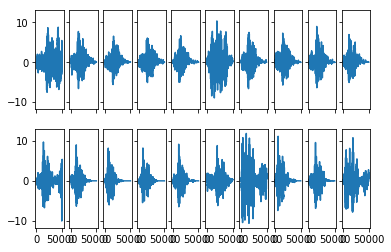

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 10, sharex=True, sharey=True)

for i in range(10):
        ax[0][i].plot(np.arange(50000),test_features_numpy[i+10,:])
for i in range(10):
        ax[1][i].plot(np.arange(50000),train_features_numpy[i+10,:])